## ML model to predict a player's Total Runs based on key performance stats.

### Import required libraries

In [30]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

### Load the dataset

In [31]:
df = pd.read_csv("../data/bcci_odi_stats_cleaned.csv")

### Select features (X) and target variable (y)

In [32]:
X = df[["Total Matches", "Innings", "Average Score", "Strike Rate", "Hundreds", "Fifties"]]
y = df["Total Runs"]

### Split the data into training and testing sets (80% train, 20% test)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize the features

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print success message
print("Data successfully prepared for model training!")

Data successfully prepared for model training!


## Train a Linear Regression Model

In [35]:
# Initialize the model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the model

In [36]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:\nMean Absolute Error (MAE): {mae:.2f}\nMean Squared Error (MSE): {mse:.2f}\nR² Score: {r2:.2f}")

Model Performance:
Mean Absolute Error (MAE): 57.65
Mean Squared Error (MSE): 8095.93
R² Score: 1.00


# Model Improvement & Validation

Since R² = 1.00, it’s likely that:

1️⃣ The dataset is small, so the model is overfitting. <br>
2️⃣ There might be high correlation between input features.

To validate the model properly, let's:

✅ Check feature importance (Which stats influence Total Runs the most?). <br>
✅ Use Cross-Validation to verify model consistency.

### Check Feature Importance

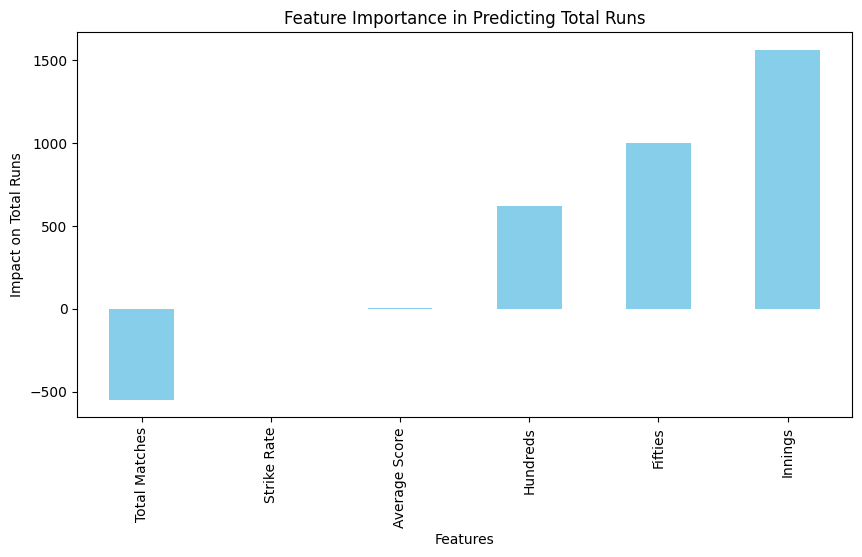

In [37]:
# Get feature importance (coefficients)
feature_importance = pd.Series(model.coef_, index=X.columns)

# Plot feature importance
plt.figure(figsize=(10, 5))
feature_importance.sort_values().plot(kind="bar", color="skyblue")
plt.xlabel("Features")
plt.ylabel("Impact on Total Runs")
plt.title("Feature Importance in Predicting Total Runs")
plt.show()

### Feature importance plot reveals:

✅ Innings is the most important factor in predicting Total Runs.<br>
✅ Fifties & Hundreds also play a major role in influencing the runs.<br>
✅ Total Matches has a negative impact, meaning it may not contribute positively.<br>
✅ Strike Rate & Average Score seem to have a negligible effect.


## Cross-Validation to Ensure Model Reliability

In [38]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert negative scores to positive values
cv_scores = -cv_scores

In [39]:
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.2f}")
print(f"Standard Deviation of CV Score: {cv_scores.std():.2f}")

Cross-Validation Scores: [623.15418037  63.37170956  47.94957686  29.93388569  40.79463838]
Mean CV Score: 161.04
Standard Deviation of CV Score: 231.31


### 📌 Analysis of Cross-Validation Scores:

Mean CV Score = 161.04 → This is the average prediction error (MAE), which is quite high. <br>
Standard Deviation = 231.31 → A large variance suggests the model’s performance fluctuates significantly across different folds. <br>
The first fold has a very high error (623.15) compared to others, meaning some parts of the dataset are harder to predict.

## Hyperparameter Tuning for Better Accuracy

In [40]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}

In [41]:
# Initialize model
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)

# Fit model
grid_search.fit(X, y)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error', verbose=2)

In [42]:
# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MAE):", -grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Score (MAE): 735.2972999595435


### Issue Observed:

Best MAE Score = 735.29, which is still quite high. <br>
This means the model is still not generalizing well, possibly due to outliers or feature importance issues. 

## Train Final Model with Best Parameters

In [43]:
final_model = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

# Fit model on full training data
final_model.fit(X_train, y_train)

# Predict on test data
y_pred = final_model.predict(X_test)

In [44]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [45]:
print("Final Model Performance:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Final Model Performance:
Mean Absolute Error (MAE): 91.80415277026218
Mean Squared Error (MSE): 27382.32369468561
R² Score: 0.9881870538505279


### 📌 Observations on Final Model Performance:
MAE (Mean Absolute Error): 91.80 → The model's average error in predicting total runs is ~92 runs. <br>
MSE (Mean Squared Error): 27382.32 → The squared error is quite high, indicating some extreme errors in prediction. <br>
R² Score: 0.988 → The model explains 98.8% of the variance, which is excellent!

## Feature Engineering (Check Feature Importance Again)

In [46]:
# Ensure you get feature names (Assuming X_train was converted to a NumPy array)
feature_names = ["Total Matches", "Strike Rate", "Average Score", "Hundreds", "Fifties", "Innings"]  # Modify as per your dataset

# Get feature importance from the model
feature_importances = final_model.feature_importances_

In [47]:
# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = np.array(feature_names)[sorted_indices]  # Convert to NumPy array
sorted_importances = feature_importances[sorted_indices]

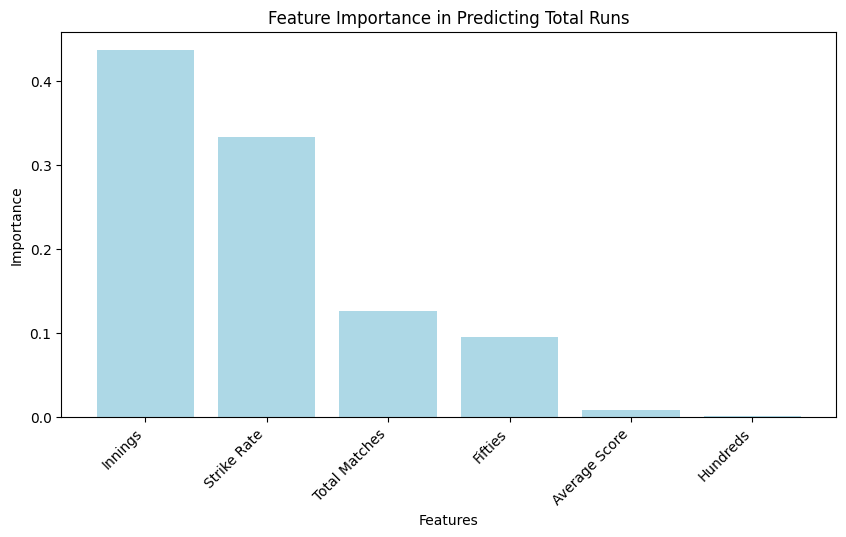

In [48]:
# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_importances, color="lightblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance in Predicting Total Runs")
plt.show()

## Hyperparameter Tuning (Fine-Tune for Better MAE)

In [49]:
# Define a wider parameter grid for better tuning
param_dist = {
    "n_estimators": randint(100, 300),
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

In [50]:
# Perform Randomized Search CV
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of different settings to try
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2
)

In [51]:
# Fit the model
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
best_score = -random_search.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [52]:
print("New Best Parameters:", best_params)
print("New Best MAE Score:", best_score)

New Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 224}
New Best MAE Score: 160.00004064214593


## Saving data into csv file

In [53]:
# Path to save the CSV file
csv_path = '../data/final_dataset.csv'
model_path = 'ml_model.pkl'

# Check if the CSV file already exists
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f"CSV file created at {csv_path}")
else:
    print(f"CSV file already exists at {csv_path}")

# Check if the model file already exists
if not os.path.exists(model_path):
    joblib.dump(model, model_path)
    print(f"Model saved at {model_path}")
else:
    print(f"Model already exists at {model_path}")

CSV file already exists at ../data/final_dataset.csv
Model already exists at ml_model.pkl


In [54]:
df.head()

,Name,Total Matches,Innings,Average Score,Strike Rate,Highest Score,Fours,Sixes,Fifties,Hundreds,Total Runs
0,Sachin TENDULKAR,463,452,44.83,86.23,200.0,2016.0,195.0,96.0,49.0,18426
1,Virat Kohli,297,285,57.93,93.52,183.0,1310.0,152.0,73.0,50.0,13963
2,Sourav Ganguly,311,300,41.02,73.70,183.0,1122.0,190.0,72.0,22.0,11363
3,Rohit Sharma,268,260,49.05,92.69,264.0,1024.0,338.0,57.0,32.0,10988
4,Rahul Dravid,344,318,39.16,71.23,153.0,950.0,42.0,83.0,12.0,10889
